In [66]:
fidx = 'irv2_'
midx = '2a'

# using results from versions of ens_oof.ipynb
mnames = ['irv2_b8']
weights = [1]

threshold = 0.51
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)
for m,w in zip(mnames,weights):
    print(w,m)
import numpy as np
print('sum of weights',sum(np.array(weights)))
# assert(len(mnames)==len(weights))

irv2_ 2a 0.51 20
1 irv2_b8
sum of weights 1


In [67]:
glist = ['iv3_b6','iv3_b9','irv2_b8']
blist = ['blend_0459']
tlist = ['iv3_a4']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 95.
gscale = 10.

['iv3_b6', 'iv3_b9', 'irv2_b8']
['blend_0459']
['iv3_a4']
['resnet34_46', 'resnet50', 'resnet34']


In [68]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [69]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [70]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [71]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [72]:
test_df.columns

Index(['Predicted'], dtype='object')

In [73]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [74]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                    
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/irv2_b8_0_mm.pkl
0.11920292202211755 0.3804523758762401 0.879869173904499
(11702, 28) 0.11920292202211755 0.3804523758762401 0.879869173904499

./sub/irv2_b8_1_mm.pkl
0.11920292202211755 0.38353184339845536 0.8621683578476202
(11702, 28) 0.11920292202211755 0.38353184339845536 0.8621683578476202
[[1.    0.915]
 [0.915 1.   ]]

./sub/irv2_b8_2_mm.pkl
0.11920292202211755 0.39305911009847205 0.7801128558285084
(11702, 28) 0.11920292202211755 0.39305911009847205 0.7801128558285084
[[1.    0.926]
 [0.926 1.   ]]

./sub/irv2_b8_3_mm.pkl
0.11920292202211755 0.38430249882976975 0.851555248895104
(11702, 28) 0.11920292202211755 0.38430249882976975 0.851555248895104
[[1.    0.933]
 [0.933 1.   ]]
irv2_b8 4 (11702, 28) 0.11920292202211755 0.3853364570507343 0.8216131862305889 0.12266828625143443


In [75]:
test_df.columns

Index(['Predicted', 'irv2_b8'], dtype='object')

In [76]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [77]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
r = np.corrcoef(f)
print(r)

['irv2_b8']
1.0


In [78]:
if len(mnames) > 1:
    d = pd.DataFrame(r, columns=mnames)
    d['id'] = mnames
    d.set_index('id',inplace=True)
    del d.index.name

    sns.clustermap(d)


    # import scipy.cluster.hierarchy as hc
    # from matplotlib import pyplot
    # link = hc.linkage(d.values, method='centroid')
    # o1 = hc.leaves_list(link)

    # mat = d.iloc[o1,:]
    # mat = mat.iloc[:, o1[::-1]]
    # pyplot.imshow(mat)

In [79]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [80]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [81]:
weights = np.array(weights)
print(weights)

[1]


In [82]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [83]:
print(ens[1])

[0.512 0.419 0.452 0.511 0.474 0.613 0.487 0.461 0.326 0.225 0.251 0.445 0.397 0.383 0.451 0.278
 0.436 0.342 0.475 0.504 0.317 0.462 0.401 0.47  0.419 0.562 0.426 0.266]


In [84]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [85]:
# desired class proportions from lb probing
eps = 0.01
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.01, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.01, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.01, 25: 0.222493888, 26: 0.028806584, 27: 0.01}


In [86]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.51
0 0.3624 0.6926 Nucleoplasm
1 0.0438 0.0663 Nuclear membrane
2 0.0753 0.1965 Nucleoli
3 0.0593 0.0842 Nucleoli fibrillar center
4 0.0753 0.0854 Nuclear speckles
5 0.0753 0.2079 Nuclear bodies
6 0.0438 0.0865 Endoplasmic reticulum
7 0.0753 0.1560 Golgi apparatus
8 0.0100 0.0004 Peroxisomes
9 0.0100 0.0006 Endosomes
10 0.0100 0.0004 Lysosomes
11 0.0438 0.0596 Intermediate filaments
12 0.0438 0.0406 Actin filaments
13 0.0142 0.0271 Focal adhesion sites
14 0.0438 0.0733 Microtubules
15 0.0100 0.0001 Microtubule ends
16 0.0288 0.0436 Cytokinetic bridge
17 0.0142 0.0214 Mitotic spindle
18 0.0288 0.0757 Microtubule organizing center
19 0.0593 0.1137 Centrosome
20 0.0100 0.0038 Lipid droplets
21 0.1261 0.4385 Plasma membrane
22 0.0288 0.0486 Cell junctions
23 0.0753 0.1838 Mitochondria
24 0.0100 0.0120 Aggresome
25 0.2225 0.7012 Cytosol
26 0.0288 0.0150 Cytoplasmic bodies
27 0.0100 0.0000 Rods & rings


In [87]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.647 1.041 0.67  0.666 0.661 0.669 0.672 0.667 0.662 0.646 0.643 1.076 1.269 1.372 1.166 0.651
 1.129 1.316 1.057 0.669 1.089 0.665 1.166 0.669 1.22  0.657 1.347 0.647]
Fractions:  [0.253 0.    0.    0.    0.001 0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.   ]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [88]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5862 0.3624 0.3624 Nucleoplasm
1 0.5510 0.0438 0.0439 Nuclear membrane
2 0.5810 0.0753 0.0753 Nucleoli
3 0.5289 0.0593 0.0594 Nucleoli fibrillar center
4 0.5169 0.0753 0.0753 Nuclear speckles
5 0.5453 0.0753 0.0753 Nuclear bodies
6 0.5374 0.0438 0.0439 Endoplasmic reticulum
7 0.5542 0.0753 0.0753 Golgi apparatus
8 0.3655 0.0100 0.0101 Peroxisomes
9 0.3241 0.0100 0.0101 Endosomes
10 0.3183 0.0100 0.0101 Lysosomes
11 0.5350 0.0438 0.0439 Intermediate filaments
12 0.5052 0.0438 0.0439 Actin filaments
13 0.5658 0.0142 0.0143 Focal adhesion sites
14 0.5858 0.0438 0.0439 Microtubules
15 0.3533 0.0100 0.0102 Microtubule ends
16 0.5315 0.0288 0.0289 Cytokinetic bridge
17 0.5346 0.0142 0.0143 Mitotic spindle
18 0.5567 0.0288 0.0289 Microtubule organizing center
19 0.5407 0.0593 0.0594 Centrosome
20 0.4458 0.0100 0.0101 Lipid droplets
21 0.5772 0.1261 0.1261 Plasma membrane
22 0.5431 0.0288 0.0289 Cell junctions
23 0.5649 0.0753 0.0753 Mitochondria
24 0.5254 0.0100 0.0101 Aggresome
25 0.5732

In [89]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [90]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.6407451717655102 6.0


In [91]:
print(sum(xps==0)/pred.shape[0])

0.06537344043753204


In [92]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2 3
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 20
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 4
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 19 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2 3', '5', '0 5 25', '0', ''

In [93]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/irv2_2a.csv


In [94]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 118 prop 0.0101
9 Endosomes count 118 prop 0.0101
10 Lysosomes count 118 prop 0.0101
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 119 prop 0.0102
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 118 prop 0.0101
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome coun

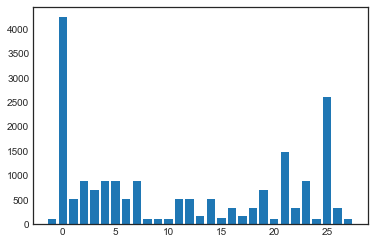

In [95]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [96]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [97]:
f1_sub(fname,'sub/protein_classification.csv')

0.5824588245060627

In [98]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5078271935273265

In [99]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5048490788536798

In [100]:
f1_sub(fname,'sub/blend_InceptionV3_InceptionResNetV2_DenseNet201_2.csv')

0.5505778898365421

In [101]:
f1_sub(fname,'sub/iv3_0.csv')

0.5614746482370526

In [102]:
f1_sub(fname,'sub/irv2_0.csv')

0.575418419893019

In [103]:
f1_sub(fname,'sub/irv2_1.csv')

0.6019569952076049

In [104]:
f1_sub(fname,'sub/irv2_2.csv')

0.7079123314680691

In [105]:
f1_sub(fname,'sub/resnet34_0.csv')

0.5835701742703397

In [106]:
f1_sub(fname,'sub/resnet50_0.csv')

0.5883150897885271

In [107]:
f1_sub(fname,'sub/resnet4.csv')

0.6288816282544571

In [108]:
f1_sub(fname,'sub/resnet5.csv')

0.5903128481050783

In [109]:
f1_sub(fname,'sub/resnet6.csv')

0.626608413594818

In [110]:
f1_sub(fname,'sub/resnet7.csv')

0.5719507735123865

In [111]:
f1_sub(fname,'sub/se_resnet1.csv')

0.5885596184673283

In [112]:
f1_sub(fname,'sub/se_resnet2.csv')

0.595895693651121

In [113]:
f1_sub(fname,'sub/se_resnext6.csv')

0.5656408474365129

In [114]:
f1_sub(fname,'sub/se_resnext9.csv')

0.5623179740223695

In [115]:
f1_sub(fname,'sub/se_resnext10.csv')

0.5883765618101784

In [116]:
f1_sub(fname,'sub/ens0.csv')

0.5671033605983765

In [117]:
f1_sub(fname,'sub/ens1.csv')

0.6067005520043456

In [118]:
f1_sub(fname,'sub/ens2.csv')

0.6039057766898124

In [119]:
f1_sub(fname,'sub/ens6.csv')

0.6230322506215691

In [120]:
f1_sub(fname,'sub/ens7.csv')

0.6122188446208512

In [121]:
f1_sub(fname,'sub/ens8.csv')

0.6479751316863601

In [122]:
f1_sub(fname,'sub/ens9.csv')

0.6583583105727578

In [123]:
f1_sub(fname,'sub/ens10.csv')

0.6653660822006221

In [124]:
f1_sub(fname,'sub/ens11.csv')

0.6577109615245956

In [125]:
f1_sub(fname,'sub/ens12.csv')

0.664931257610316

In [126]:
f1_sub(fname,'sub/ens13.csv')

0.5656505220609596

In [127]:
f1_sub(fname,'sub/ens14.csv')

0.6622248953003013

In [128]:
f1_sub(fname,'sub/ens15.csv')

0.6636927940150192

In [129]:
f1_sub(fname,'sub/ens16.csv')

0.667919390515021

In [130]:
print(fname)

sub/irv2_2a.csv
